In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [3]:
dataframe = pd.read_csv('data_full.csv')

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_62563/854334815.py:1: DtypeWarning: Columns (2,5,6,8,10,11,14,15,16,17,18,19,20,21,23,24,25,27,28,32) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('data_full.csv')


In [253]:
dataframe.head(10)

,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,uses_credit,num_products,date_of_creating_new_columns,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product
0,1.0,409968.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,2,2023-03-30,NaN,NaN,238.0,542.0,NaN,relay,loan
1,1.0,409998.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-03-30,NaN,NaN,NaN,2068.0,NaN,loan,NaN
2,1.0,410044.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-03-30,NaN,NaN,NaN,598.0,NaN,loan,NaN
3,1.0,410064.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,2,2023-03-30,NaN,NaN,121.0,122.0,NaN,relay,loan
4,1.0,410079.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-03-30,NaN,NaN,43.0,NaN,NaN,relay,NaN
5,1.0,410080.0,2020-03-11,2.0,153466.27,2019-11-04,Active,789.0,2023-03-21,38.48,...,False,2,2023-03-30,1114.0,1242.0,NaN,NaN,NaN,invest,money
6,1.0,410093.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-03-30,NaN,NaN,NaN,181.0,NaN,loan,NaN
7,1.0,410123.0,2020-03-12,1.0,8839.55,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-03-30,1113.0,NaN,NaN,NaN,NaN,invest,NaN
8,1.0,410124.0,2021-10-24,1.0,5303.97,NaT,NaN,NaN,NaN,NaN,...,False,2,2023-03-30,522.0,NaN,263.0,NaN,NaN,relay,invest
9,1.0,410135.0,2020-03-11,2.0,5980.08,2020-04-09,Active,NaN,2023-03-21,10.00,...,False,2,2023-03-30,1114.0,1085.0,NaN,NaN,NaN,money,invest


In [4]:
## Chase's code

#create columns that show if a person uses a product
dataframe["uses_invest"] = ~dataframe['INV_OPEN_DATE'].isna() 
dataframe["uses_money"] = ~dataframe['MONEY_ACCOUNT_OPEN_DATE'].isna()
dataframe["uses_relay"] = ~dataframe['RELAY_ORIGINAL_DATE'].isna() 
dataframe["uses_loan"] = ~dataframe['ORIGINATION_DATE'].isna()
dataframe["uses_credit"] = ~dataframe['ONBOARDING_SUCCESS_DATE'].isna()

#create column that shows how many products a person uses
dataframe["num_products"] = (dataframe[['uses_invest', 'uses_money', 'uses_relay', 'uses_loan', 'uses_credit']] == True).sum(axis=1)

# create a column that shows how long a person has used a product. If they have never used a product, it will be NaN

dataframe['date_of_creating_new_columns'] = pd.to_datetime('today').date()

dataframe['INV_OPEN_DATE'] = pd.to_datetime(dataframe['INV_OPEN_DATE']).dt.date
dataframe['days_with_invest'] = (dataframe['date_of_creating_new_columns'] - dataframe['INV_OPEN_DATE']).dt.days

dataframe['MONEY_ACCOUNT_OPEN_DATE'] = pd.to_datetime(dataframe['MONEY_ACCOUNT_OPEN_DATE']).dt.date
dataframe['days_with_money'] = (dataframe['date_of_creating_new_columns'] - dataframe['MONEY_ACCOUNT_OPEN_DATE']).dt.days

dataframe['RELAY_ORIGINAL_DATE'] = pd.to_datetime(dataframe['RELAY_ORIGINAL_DATE']).dt.date
dataframe['days_with_relay'] = (dataframe['date_of_creating_new_columns'] - dataframe['RELAY_ORIGINAL_DATE']).dt.days

dataframe['ORIGINATION_DATE'] = pd.to_datetime(dataframe['ORIGINATION_DATE']).dt.date
dataframe['days_with_loan'] = (dataframe['date_of_creating_new_columns'] - dataframe['ORIGINATION_DATE']).dt.days

dataframe['ONBOARDING_SUCCESS_DATE'] = pd.to_datetime(dataframe['ONBOARDING_SUCCESS_DATE']).dt.date
dataframe['days_with_credit'] = (dataframe['date_of_creating_new_columns'] - dataframe['ONBOARDING_SUCCESS_DATE']).dt.days

# create a column 'first_product' that shows the first product a person used, and a column 'second_product' that shows the second product a person used. If they have never used a second product, it will be NaN

dataframe['first_product'] = np.nan
dataframe['second_product'] = np.nan

first_product_list = []
second_product_list = []

for i in tqdm(range(len(dataframe))):
    #create a list of the products that the user has
    products = []
    if dataframe.loc[i, 'uses_relay'] == True:
        products.append('relay')
    if dataframe.loc[i, 'uses_money'] == True:
        products.append('money')
    if dataframe.loc[i, 'uses_invest'] == True:
        products.append('invest')
    if dataframe.loc[i, 'uses_loan'] == True:
        products.append('loan')
    if dataframe.loc[i, 'uses_credit'] == True:
        products.append('credit')

    

    #sort the list of products by the number of days the user has used the product
    products.sort(key=lambda x: dataframe.loc[i, f'days_with_{x}'], reverse=True)

    #add the first two products to the list
    if len(products) >= 1:
        first_product_list.append(products[0])
    else:
        first_product_list.append(np.nan)
    if len(products) >= 2:
        second_product_list.append(products[1])
    else:
        second_product_list.append(np.nan)
        

dataframe['first_product'] = first_product_list
dataframe['second_product'] = second_product_list

100%|██████████| 3216851/3216851 [03:35<00:00, 14917.41it/s]


In [5]:
dataframe.head()

,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,uses_credit,num_products,date_of_creating_new_columns,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product
0,1.0,409968.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,2,2023-04-03,NaN,NaN,242.0,546.0,NaN,loan,relay
1,1.0,409998.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-04-03,NaN,NaN,NaN,2072.0,NaN,loan,NaN
2,1.0,410044.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-04-03,NaN,NaN,NaN,602.0,NaN,loan,NaN
3,1.0,410064.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,2,2023-04-03,NaN,NaN,125.0,126.0,NaN,loan,relay
4,1.0,410079.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,False,1,2023-04-03,NaN,NaN,47.0,NaN,NaN,relay,NaN


In [6]:
def analyze_relay(product):
    df = dataframe[dataframe['first_product'] == 'relay']
    cols = list(df.columns[13:21]) # relay columns

    # identify the desired target product
    if(product == 'PL'):
        drop_columns = ['PL_ACTIVE_IND']
        cols.append('REL_LOAN_SQS')
        df['response'] = (dataframe['second_product'] == 'loan')

    if(product == 'Money'):
        drop_columns = ['BANKING_ACTIVE_IND']
        cols.append('REL_MON_SQS')
        df['response'] = (dataframe['second_product'] == 'money')

    cols.append('response') # response variable
    df = df[cols]
    df = df.drop(columns=drop_columns)
    df.fillna(False,inplace=True)

    #downsample the data to balance the response variable (uses_money) (majority are users that do not use money and only use 1 product)
    #df = analyze_relay('PL')
    # Separate majority class (uses_money = 0 and num_products = 1)
    data_majority = df[df['response'] == False]
    data_minority = df[df['response'] == True]

    # Downsample majority class
    data_majority_downsampled = resample(data_majority, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(data_minority),     # to match minority class
                                        random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    data_downsampled = pd.concat([data_majority_downsampled, data_minority])

    ## model
    X_train, X_test, y_train, y_test = train_test_split(data_downsampled[data_downsampled.columns[:-1]], data_downsampled['response'], test_size=0.33, random_state=34)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # check the accuracy
    accuracy = "ACCURACY: "+str(accuracy_score(y_test, y_pred))

    # find coefficients
    coefs = pd.DataFrame(zip(X_train.columns, np.transpose(model.coef_)), columns=['features', 'coef']) 

    # normalizing
    #for i in range(coefs.shape[0]):
        #coefs.iloc[i, 1] = math.exp(coefs.iloc[i, 1]) / (1 + math.exp(coefs.iloc[i, 1]))

    return coefs, accuracy, model, df



In [7]:
pl = analyze_relay('PL')
print(pl[1])
pl[0]

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_62563/4193411136.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = (dataframe['second_product'] == 'loan')


ACCURACY: 0.8600912879539592


,features,coef
0,RELAY_FICO,[0.015750095319018467]
1,SL_ACTIVE_IND,[-0.8874145864095302]
2,MORTGAGE_ACTIVE_IND,[-0.06460065187655219]
3,BANKING_ACTIVE_IND,[-2.4572820497143835]
4,INVEST_ACTIVE_IND,[-1.1378931841670865]
5,CC_ACTIVE_IND,[0.9797485668996045]
6,CSM_ACTIVE_IND,[-4.752025247447877]
7,REL_LOAN_SQS,[1.727423860561842]


In [247]:
pl = analyze_relay('PL')
print(pl[1])
pl[0]
# 0.7969615237731525

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_35408/4193411136.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = (dataframe['second_product'] == 'loan')


ACCURACY: 0.7969615237731525


,features,coef
0,RELAY_FICO,[0.013462520106756776]
1,SL_ACTIVE_IND,[-0.61375014629891]
2,MORTGAGE_ACTIVE_IND,[0.0905584294450642]
3,BANKING_ACTIVE_IND,[-0.8592045474719718]
4,INVEST_ACTIVE_IND,[-0.6596444860611291]
5,CC_ACTIVE_IND,[-0.24356921940026768]
6,CSM_ACTIVE_IND,[-4.341849984134671]
7,REL_LOAN_SQS,[0.0]


potential issue with people being able to start relay tracking after they open the product of choice. so like they start tracking an additional product after they have already opened the app

In [8]:
# Display new class counts
data = pl[3]
data['response'].value_counts()

False    1174600
True        7634
Name: response, dtype: int64

In [248]:
money = analyze_relay('Money')
print(money[1])
money[0]
# 0.6472421834102698 SQS Accuracy
# 0.6508907184441377 MQS Accuracy

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_35408/4193411136.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = (dataframe['second_product'] == 'money')


ACCURACY: 0.6508907184441377


,features,coef
0,RELAY_FICO,[0.0025036021422624585]
1,SL_ACTIVE_IND,[-1.0147253754124046]
2,PL_ACTIVE_IND,[-1.326671859845438]
3,MORTGAGE_ACTIVE_IND,[-0.08234455651345565]
4,INVEST_ACTIVE_IND,[0.28125385984006385]
5,CC_ACTIVE_IND,[-0.31433975500486855]
6,CSM_ACTIVE_IND,[-0.6188729735226028]
7,REL_MON_SQS,[0.14463632280220498]


In [265]:
dataframe.columns

Index(['ROW_NUM', 'USER_ID', 'INV_OPEN_DATE', 'INV_NUM_ACCOUNTS',
       'INV_ACC_BAL', 'MONEY_ACCOUNT_OPEN_DATE', 'MONEY_ACCOUNT_STATUS',
       'MONEY_FICO', 'MONEY_DATA_UPDATE_DATE', 'MONEY_TOTAL_BALANCE',
       'LAST_PAYMENT_DATE', 'ORIGINATION_DATE', 'PRINCIPAL', 'RELAY_FICO',
       'SL_ACTIVE_IND', 'PL_ACTIVE_IND', 'MORTGAGE_ACTIVE_IND',
       'BANKING_ACTIVE_IND', 'INVEST_ACTIVE_IND', 'CC_ACTIVE_IND',
       'CSM_ACTIVE_IND', 'ACTIVE', 'TOTAL_RECENCY_DAYS', 'RELAY_ORIGINAL_DATE',
       'ONBOARDING_SUCCESS_DATE', 'FIRST_TRANSACTION_DATE', 'CREDIT_LINE',
       'CURRENT_CYCLE_BEHAVIOR_SEGMENT', 'MQS_REPORTING_DATE', 'REL_MON_MQS',
       'REL_INV_MQS', 'REL_LOAN_MQS', 'SQS_DATE_EST', 'REL_MON_SQS',
       'REL_INV_SQS', 'REL_LOAN_SQS', 'uses_invest', 'uses_money',
       'uses_relay', 'uses_loan', 'uses_credit', 'num_products',
       'date_of_creating_new_columns', 'days_with_invest', 'days_with_money',
       'days_with_relay', 'days_with_loan', 'days_with_credit',
       'f

In [10]:
dataframe['xbuy_days'] = np.isnan
dataframe['xbuy_date'] = np.isnan
dataframe['first_30'] = np.isnan

for i in tqdm(range(dataframe.shape[0])):
    first = dataframe.at[i, 'first_product']
    second = dataframe.at[i, 'second_product']
    if(pd.isnull(first) == False and pd.isnull(second) == False):
        if(first == 'relay'):    
            first_date = dataframe.at[i, 'days_with_relay']
        elif(first == 'loan'):
            first_date = dataframe.at[i, 'days_with_loan']
        elif(first == 'money'):
            first_date = dataframe.at[i, 'days_with_money']
        elif(first == 'invest'):
            first_date = dataframe.at[i, 'days_with_invest']
        elif(first == 'credit'):
            first_date = dataframe.at[i, 'days_with_invest']

        if(second == 'relay'):    
            second_date = dataframe.at[i, 'days_with_relay']
            date_xbuy = dataframe.at[i, 'RELAY_ORIGINAL_DATE']
        elif(second == 'loan'):
            second_date = dataframe.at[i, 'days_with_loan']
            date_xbuy = dataframe.at[i, 'ORIGINATION_DATE']
        elif(second == 'money'):
            second_date = dataframe.at[i, 'days_with_money']
            date_xbuy = dataframe.at[i, 'MONEY_ACCOUNT_OPEN_DATE']
        elif(second == 'invest'):
            second_date = dataframe.at[i, 'days_with_invest']
            date_xbuy = dataframe.at[i, 'INV_OPEN_DATE']
        elif(second == 'credit'):
            second_date = dataframe.at[i, 'days_with_invest']
            date_xbuy = dataframe.at[i, 'ONBOARDING_SUCCESS_DATE']

        xbuy_days = first_date - second_date
        dataframe.at[i, 'xbuy_days'] =  xbuy_days
        dataframe.at[i, 'xbuy_date'] = date_xbuy
        
    else: 
        xbuy_days = np.nan
        dataframe.at[i, 'xbuy_days'] = np.nan
        dataframe.at[i, 'xbuy_date'] = np.nan
        dataframe.at[i, 'first_30'] = False
    
    if(np.isnan(xbuy_days) != True):
        dataframe['first_30'] = (abs(xbuy_days) <= 30)
    
    
    


100%|██████████| 3216851/3216851 [15:13<00:00, 3522.22it/s]


In [1]:
dataframe.head(50)

NameError: name 'dataframe' is not defined

In [14]:
xbuy = dataframe[pd.isnull(dataframe['xbuy_days']) != True]
xbuy.head(30)

,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product,xbuy_days,xbuy_date,first_30
0,1.0,409968.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,242.0,546.0,NaN,loan,relay,304.0,2022-08-04,False
3,1.0,410064.0,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,125.0,126.0,NaN,loan,relay,1.0,2022-11-29,False
5,1.0,410080.0,2020-03-11,2.0,153466.27,2019-11-04,Active,789.0,2023-03-21,38.48,...,1118.0,1246.0,NaN,NaN,NaN,money,invest,128.0,2020-03-11,False
8,1.0,410124.0,2021-10-24,1.0,5303.97,NaT,NaN,NaN,NaN,NaN,...,526.0,NaN,267.0,NaN,NaN,invest,relay,259.0,2022-07-10,False
9,1.0,410135.0,2020-03-11,2.0,5980.08,2020-04-09,Active,NaN,2023-03-21,10.00,...,1118.0,1089.0,NaN,NaN,NaN,invest,money,29.0,2020-04-09,False
10,1.0,410145.0,2020-03-13,1.0,8369.13,NaT,NaN,NaN,NaN,NaN,...,1116.0,NaN,424.0,NaN,NaN,invest,relay,692.0,2022-02-03,False
12,1.0,410151.0,NaT,NaN,NaN,2022-03-06,Active,791.0,2023-03-21,1.00,...,NaN,393.0,744.0,NaN,NaN,relay,money,351.0,2022-03-06,False
14,1.0,410169.0,2020-03-12,1.0,387461.25,2022-02-02,Active,740.0,2023-03-21,151.44,...,1117.0,425.0,46.0,409.0,NaN,invest,money,692.0,2022-02-02,False
22,1.0,410264.0,2018-05-22,2.0,213061.31,2019-01-25,Active,792.0,2023-03-21,16906.21,...,1777.0,1529.0,197.0,NaN,NaN,invest,money,248.0,2019-01-25,False
27,1.0,410364.0,2017-12-07,2.0,7894418.15,2019-02-27,Active,792.0,2023-03-21,1034.33,...,1943.0,1496.0,450.0,NaN,NaN,invest,money,447.0,2019-02-27,False


In [12]:
dates = pd.date_range('1/1/2021', '1/1/2023').tolist()
day_map = dict.fromkeys(dates, 0)
for day in dates:
    temp = dataframe[dataframe['xbuy_date'] == day]
    col = temp['xbuy_days']
    day_map[day] = col.mean()

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_62563/3274569666.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  temp = dataframe[dataframe['xbuy_date'] == day]


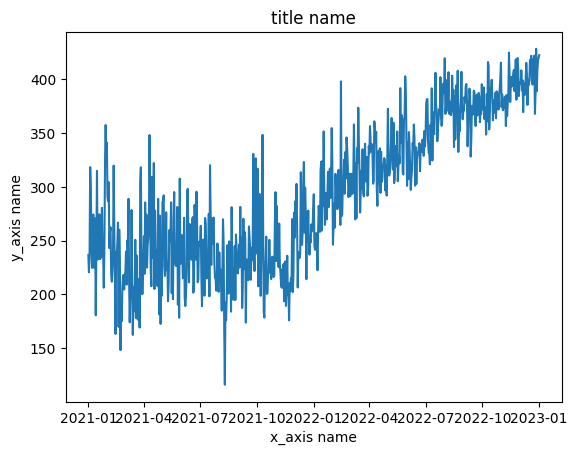

In [13]:
plt.plot(day_map.keys(), day_map.values())
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
#plt.xlim(left=datetime.date(20, 1, 1))
plt.show()

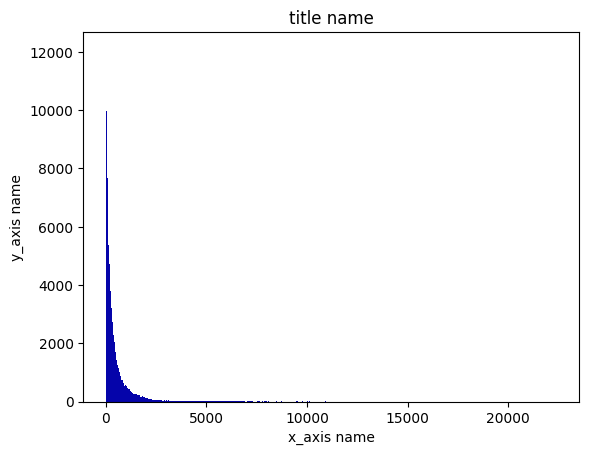

In [15]:
relay = xbuy[xbuy['first_product'] == 'relay']
plt.hist(x=relay['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
#plt.xlim(left=datetime.date(20, 1, 1))
plt.show()

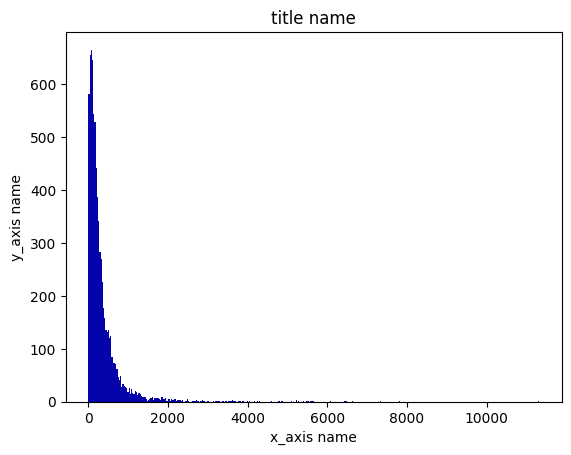

In [17]:
relay_pl = xbuy[xbuy['first_product'] == 'relay']
relay_pl =  relay_pl[relay_pl['second_product'] == 'loan']
plt.hist(x=relay_pl['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
#plt.xlim(left=datetime.date(20, 1, 1))
plt.show()

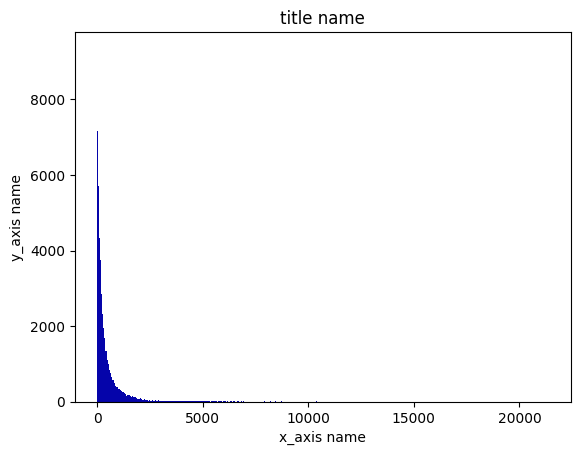

In [18]:
relay_money = xbuy[xbuy['first_product'] == 'relay']
relay_money = relay_money[relay_money['second_product'] == 'money']
plt.hist(x=relay_money['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
#plt.xlim(left=datetime.date(20, 1, 1))
plt.show()

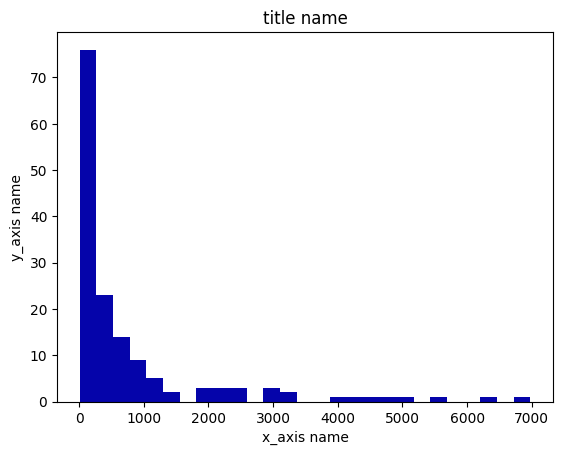

In [19]:
relay_credit = xbuy[xbuy['first_product'] == 'relay']
relay_credit = relay_credit[relay_credit['second_product'] == 'credit']
plt.hist(x=relay_credit['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
#plt.xlim(left=datetime.date(20, 1, 1))
plt.show()